# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [27]:
import numpy as np
import pandas as pd

# библиотека байесовских алгоритмов
from sklearn import naive_bayes

from sklearn import metrics
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt #для визуализации
import seaborn as sns 
import plotly

In [2]:
# откройте данные: 
df = pd.read_csv('data/spam_or_not_spam.csv')
display(df.head())

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [3]:
# рассчитайте частоты для классов где 1 это спам, а 0 не спам
group_df = df.groupby('label').count()
print(group_df)

       email
label       
0       2500
1        499


<AxesSubplot: title={'center': 'Распределение классов спам или не спам'}, xlabel='label'>

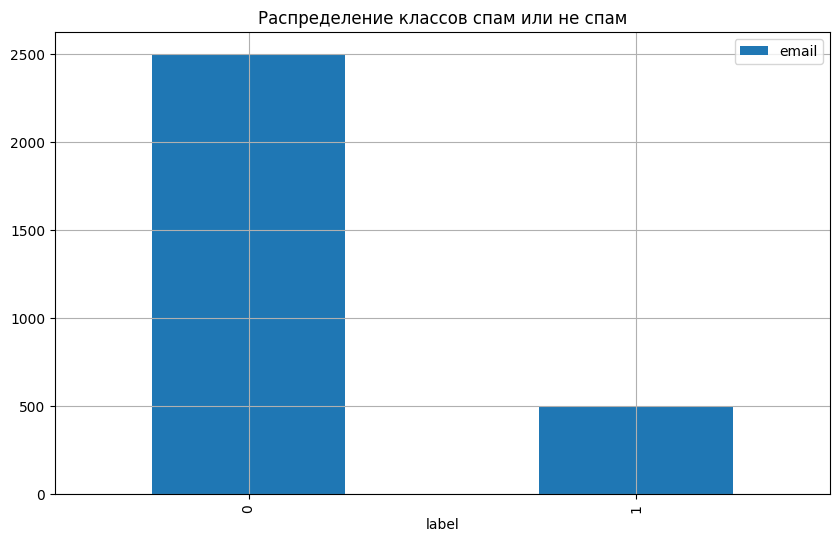

In [4]:
# визуализируйте результат: ваш код здесь
group_df.plot(
    kind='bar',
    figsize=(10,6),
    title='Распределение классов спам или не спам',
    grid=True
)

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [6]:
# делаем копию датасета
data_clean = df.copy()

# удаляем пропуски
data_clean['email'] = data_clean['email'].replace(r'^\s*$', np.nan, regex=True)
data_clean.dropna(how='any', inplace=True)

# выводим результат
data_clean.info()
data_clean.shape
data_clean.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 2997 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2997 non-null   object
 1   label   2997 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 70.2+ KB


email    0
label    0
dtype: int64

Переводим данные в векторный вид:

In [7]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_clean["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [8]:
print(f'После обработки создано {X.shape[1]} признаков')

После обработки создано 34116 признаков


## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [9]:
# Зададим целевую переменную
y= data_clean['label']
# выводим результат
print(f'Размер обучающей выборки: {X.shape}')
print(f'Размер тестовой выборки: {y.shape}')

Размер обучающей выборки: (2997, 34116)
Размер тестовой выборки: (2997,)


Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.75,
    test_size=0.25,
    stratify=y,
    random_state=42
)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [11]:
print(round(y_test.mean(), 3))

0.165


## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [12]:
# Наиболее подходящие классификаторы - MultinomialNB & ComplementNB, 
# поскольку ComplementNB улучшенная версия MultinomialNB, то его и будем применять.
# задаём объект класса ComplementNB
CNB = naive_bayes.ComplementNB(alpha=0.01)

# обучаем модель
CNB.fit(X_train, y_train)

# предсказываем значения на тестовой выборке
y_pred_cnb = CNB.predict(X_test)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [17]:
print(metrics.classification_report(y_test, y_pred_cnb))
print(metrics.accuracy_score(y_test,y_pred_cnb))
print(metrics.precision_score(y_test,y_pred_cnb))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       626
           1       1.00      0.93      0.96       124

    accuracy                           0.99       750
   macro avg       0.99      0.96      0.98       750
weighted avg       0.99      0.99      0.99       750

0.988
1.0


Нарисуйте ROC-кривую:

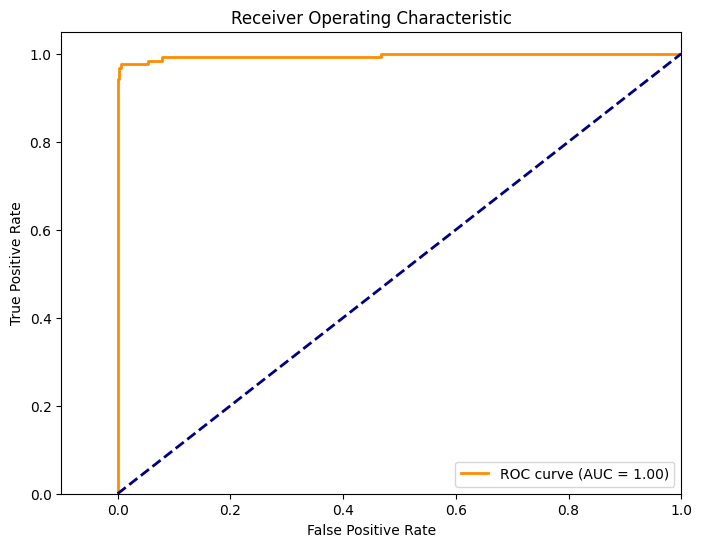

In [26]:
y_pred_proba = CNB.predict_proba(X_test)
#Строим кривую
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba[:,1])
auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])

#create ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [29]:
for i in [1, 0.1, 0.01, 0.001, 0.0001]:
    clf = naive_bayes.ComplementNB(alpha=i)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f'Альфа = {i}: среднее значение accuracy = {round(scores.mean(),3)}, стандартное отклонение = {round(scores.std(), 3)}')

Альфа = 1: среднее значение accuracy = 0.99, стандартное отклонение = 0.003
Альфа = 0.1: среднее значение accuracy = 0.99, стандартное отклонение = 0.004
Альфа = 0.01: среднее значение accuracy = 0.989, стандартное отклонение = 0.003
Альфа = 0.001: среднее значение accuracy = 0.987, стандартное отклонение = 0.005
Альфа = 0.0001: среднее значение accuracy = 0.984, стандартное отклонение = 0.007
